In [287]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import sys

In [288]:
%matplotlib notebook

In [289]:
g0 = 9.81

T_C = 28 + 273.15
D = 0.25

r_a = 1.12
r_V = 0.21
r_T = 0.060

T_H = T_C / (1-r_T)  # hot temperature
H = D*r_a  # height

rho0_oil = 1080  # density at room temp
rho0_ss = 1074  # density of ss
c_oil = 1591
c_ss = 3993

V_tot = np.pi * (D/2)**2 * H
m = (V_tot * r_V/(1+r_V)) * rho0_oil

In [301]:
m=0.1

In [302]:
# thermo constants
eta = 1.08e-3  # viscosity of ss (Pa s)
# eta = 0.5
b = 1
h = 100  # heat transfer coefficient

In [303]:
def rho_oil(T):
    return 958.766 + 1.31955 * T - 0.00307241*T*T

def rho_ss(T):
    return 745.901 + 2.39312 * T - 0.00434063*T*T

In [304]:
def T(x):
    return x/H * (T_C-T_H) + T_H

In [305]:
def f(t, y):
    rho = rho_oil(y[2])
    r = ((3*m/rho)/(4*np.pi))**(1.0/3)
#     print(f'm: {m}')
#     print(f'rho: {rho}')
#     print(f'T: {y[2]}')
#     print(f'r: {r}')
    dx = -g0 + rho_ss(T(y[0]))/rho * g0 - 6*np.pi*eta*r*y[1]/m
    dT = (h*(4*np.pi*r**2)*(T(y[0])-y[2])**b) / (c_oil*m)
    
    if (y[0] >= H):
        y[1] = min(0, y[1])
        dx = min(0, dx)
        
    if (y[0] <= 0):
        y[1] = max(0, y[1])
        dx = max(0,dx)
        
#     if(np.isnan(r)):
#         print(m, rho)
        
    return [y[1], dx, dT]

In [306]:
t_eval = np.linspace(0, 5000, 10000)
# t_eval = np.linspace(0, 30000, 10000)
t_span = (t_eval[0], t_eval[-1])
y0 = [0, 0, T_C]

In [307]:
sol = solve_ivp(f, t_span, y0)

<ipython-input-305-8533ed61ee5e>:3: RuntimeWarning: invalid value encountered in double_scalars
  r = ((3*m/rho)/(4*np.pi))**(1.0/3)


<IPython.core.display.Javascript object>


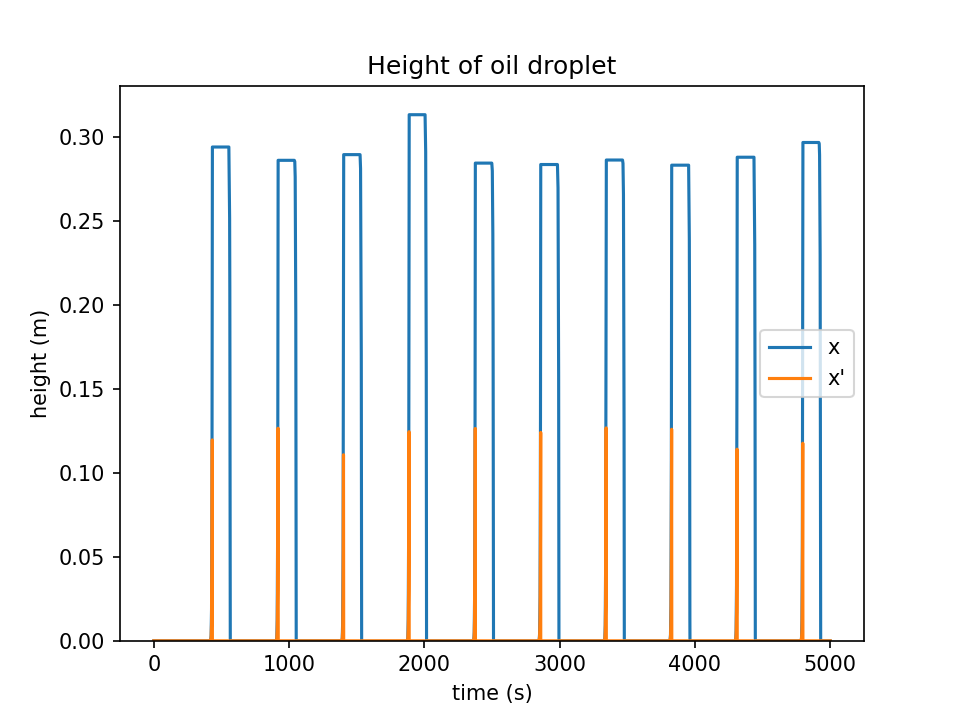

In [308]:
plt.figure()
plt.plot(sol.t, sol.y[0], label='x')
plt.plot(sol.t, sol.y[1], label='x\'')
plt.title('Height of oil droplet')
plt.ylabel('height (m)')
plt.xlabel('time (s)')
plt.ylim(0, H+0.05)
plt.legend()

<IPython.core.display.Javascript object>


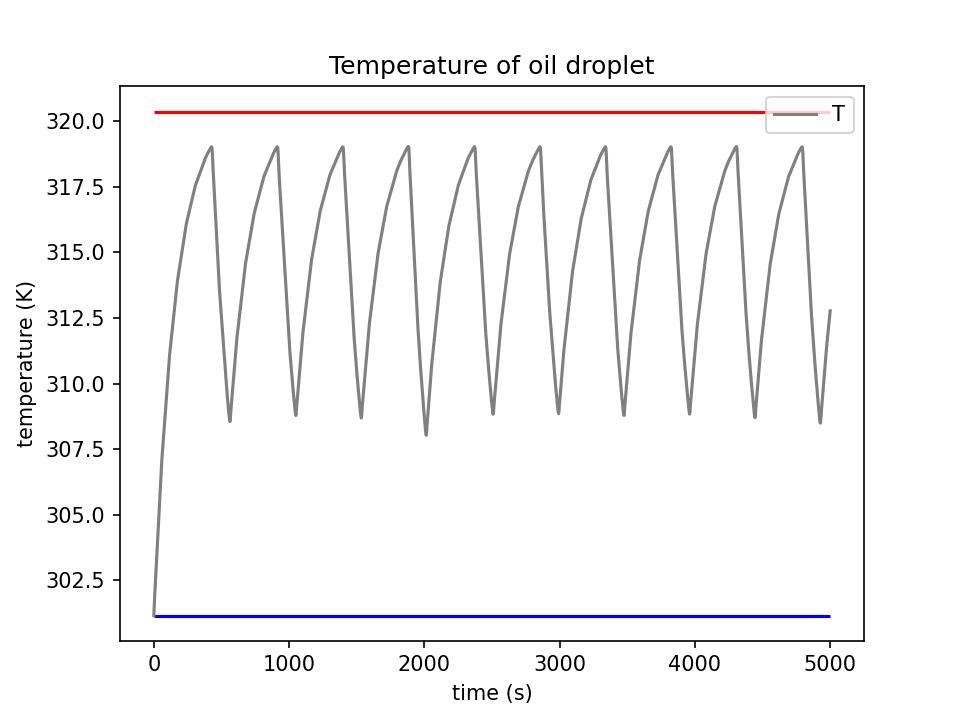

In [309]:
plt.figure()
# plt.plot(sol.t, sol.y[0], label='x')
# plt.plot(sol.t, sol.y[1], label='dx')
plt.plot(sol.t, sol.y[2], label='T', c='gray')
plt.hlines(T_C, t_span[0], t_span[1], colors='blue')
plt.hlines(T_H, t_span[0], t_span[1], colors='red')
plt.title('Temperature of oil droplet')
plt.ylabel('temperature (K)')
plt.xlabel('time (s)')
plt.legend()

In [106]:
t_eval

array([0.00000e+00, 1.00001e-02, 2.00002e-02, ..., 9.99980e+02,
       9.99990e+02, 1.00000e+03])

## temp and height

<IPython.core.display.Javascript object>


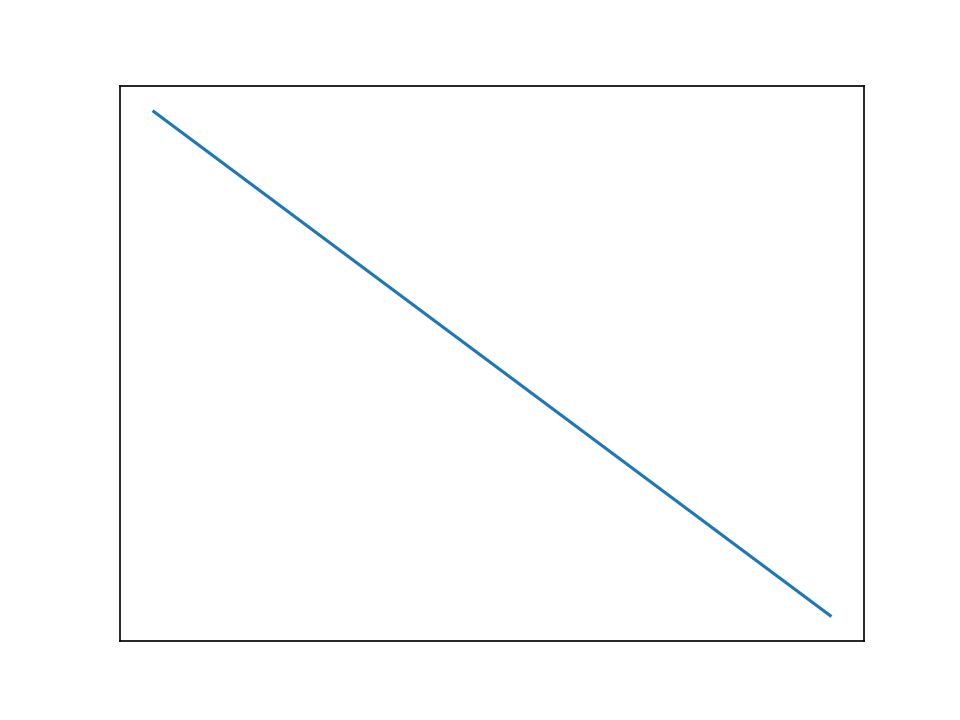

([], [])

In [14]:
plt.figure()
xs = np.linspace(0,H,5)
plt.plot(xs, [T(x) for x in xs])
plt.xticks([])
plt.yticks([])

# Heat transfer coefficient and period of oscillations

In [234]:
def period(sol):
    periods = []
    start = 0
    for i in range(10, len(sol.y[0])):
        if(sol.y[0][i] >= H and sol.y[0][i-1] < H):
            if (start>0):
                periods.append(sol.t[i]-sol.t[start])

            start = i
    
    return np.mean(periods)

In [235]:
steps = 50
Hs = np.geomspace(10, 10000, steps)
taus = np.zeros(steps)

In [236]:
for i in range(steps):
    sys.stderr.write(f'{i}\r')
    h = Hs[i]
    taus[i] = period(solve_ivp(f, t_span, y0))

<ipython-input-213-8533ed61ee5e>:3: RuntimeWarning: invalid value encountered in double_scalars
  r = ((3*m/rho)/(4*np.pi))**(1.0/3)


In [237]:
taus

array([13459.36578259, 11674.17074229, 10167.34527299,  8801.13698599,
        7662.30675439,  6670.60441419,  5803.57562517,  5051.52251017,
        4393.41288928,  3814.02122731,  3326.05801494,  2887.88735882,
        2516.82971371,  2193.12951358,  1910.83562236,  1663.50229487,
        1450.95316329,  1264.83378152,  1104.22043034,   963.60894001,
         840.94444054,   735.4400019 ,   643.27024919,   562.65036212,
         492.71127038,   431.96607745,   379.19022084,   333.15922087,
         292.9269355 ,   257.87337648,   227.27838155,   200.60471089,
         177.39591142,   157.05727555,   139.12679762,   123.60497488,
         110.02568127,    98.1307666 ,    87.65395139,    78.46960819,
          70.43732132,    63.36777627,    57.15487333,    51.67263365,
          46.98271712,    42.67728682,    39.03707413,    35.71849305,
          32.89184205,    30.53910962])

<IPython.core.display.Javascript object>


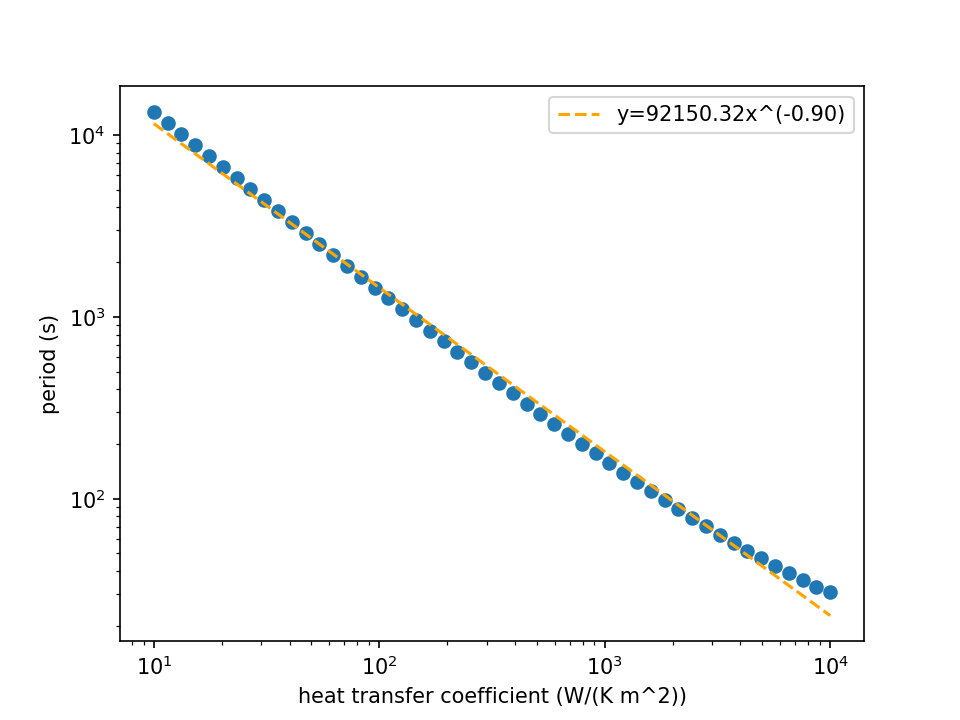

In [255]:
plt.figure()
plt.scatter(Hs, taus)
plt.xscale('log')
plt.yscale('log')
fit = np.polyfit(np.log(Hs), np.log(taus), 1)
plt.plot(Hs, np.exp(np.poly1d(fit)(np.log(Hs))), '--', c='orange', label=f'y={np.exp(fit[1]):.2f}x^({fit[0]:.2f})')
plt.legend()

In [257]:
plt.xlabel('heat transfer coefficient (W/(K m^2))')
plt.ylabel('period (s)')

Text(59.97230183919272, 0.5, 'period (s)')

In [ ]:
np.polyfit(np., numpy.log(y), 1)

# Conduction model